In [46]:
import pandas as pd
import plotly.express as px
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Getting DF
tweetsdf = pd.read_csv('../data/finalScores.csv').dropna(subset=['score'])
tweetsdf = tweetsdf.iloc[:,2:]
tweetsdf.head()

,date,tweet,user_id,latitude,longitude,hashtags,original_tweet,score
0,2006-09-10 11:07:07,trying to figure out what this thing is,5622.0,39.1413,-84.506,NaN,trying to figure out what this thing is.,4.154872
1,2007-03-17 09:59:46,killing my land line,5622.0,39.1413,-84.506,NaN,killing my land line.,4.375000
2,2007-03-18 11:48:24,my expense report,5622.0,39.1413,-84.506,NaN,my expense report,4.275294
3,2007-03-21 12:20:05,putting down the llama book,5622.0,39.1413,-84.506,NaN,putting down the llama book.,4.258095
5,2007-04-23 16:33:41,releasing final art,5622.0,39.1413,-84.506,NaN,Releasing Final Art.,4.528889


In [68]:
tweetsdf.dropna(subset=['hashtags'])

,date,tweet,user_id,latitude,longitude,hashtags,original_tweet,score
94,2009-10-24 19:53:09,school of cock,753393.0,34.11410,-118.4068,oneletteroffmovies,@SarahKSilverman School of Cock #oneletteroffm...,4.192857
315,2007-03-23 01:56:29,bomb this wont happen again i promise,1983121.0,45.31090,-122.7702,1,"Bomb #1, This wont happen again, I promise!",4.245946
317,2007-03-23 01:56:30,bomb this wont happen again i promise,1983121.0,45.31090,-122.7702,2,"Bomb #2, This wont happen again, I promise!",4.245946
355,2009-05-13 13:38:06,im sure im late with this but here you go,1925401.0,42.38890,-71.2423,imw051309,@gregorysimpson i'm sure i'm late with this bu...,3.956098
363,2009-06-20 09:45:55,i also want to send support to everyone in ira...,1925401.0,42.38890,-71.2423,teaparty,@jillwhalen i also want to send support to eve...,4.078384
...,...,...,...,...,...,...,...,...
8681398,2010-03-16 12:17:28,trt shay was whoopin dat assstop lyin lol,58669408.0,43.02179,-83.6757,whenifirstmet,TRT @kyekye22: #whenifirstmet @DineroMEECH Sha...,4.132727
8681399,2010-03-16 12:17:51,rt he blew the games for us at this tournament...,58669408.0,43.02179,-83.6757,wheniirstmet,RT @smittylu: #wheniirstmet @DineroMEECH he bl...,3.944815
8681415,2010-03-16 12:58:33,just saw measurements that is i need see th...,58669408.0,43.02179,-83.6757,unreal,Just saw @cherokeedassxxx measurements: 36-29-...,4.091636
8681423,2010-03-16 13:19:24,rtdineromeech it was at my hotel partyi though...,58669408.0,43.02179,-83.6757,"whenifirstmet,nolie",RT @CharmaineBryant: #WhenIFirstMet-->>@Dinero...,3.905769


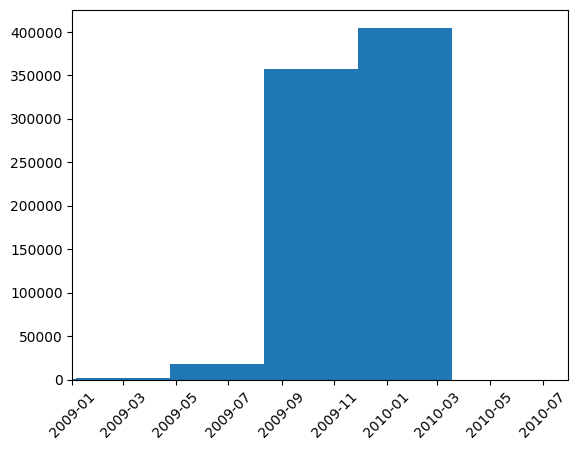

In [67]:
plt.hist(tweetsdf.dropna(subset=['hashtags'])['date'])
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp('2009-01-01'), pd.Timestamp('2010-07-31'))
plt.show()

In [6]:
# Converting date field to datetime object
tweetsdf['date'] = pd.to_datetime(tweetsdf['date'])

## Analyzing Positive Event Impact
Positive events:
- Christmas/Holiday season 2009 
- October 2009 NASA launching Ares-I X Mission 
- Fourth of July 2009 Statue of Liberty reopening
- 2010 Winter Olympics

In [14]:
# Dates/Starts of positive events
positiveEventDates = {
    'christmas': pd.Timestamp('2009-12-25'),
    'nasa': pd.Timestamp('2009-10-28'),
    'liberty': pd.Timestamp('2009-07-04'),
    'olympics': pd.Timestamp('2010-02-12')
}

In [56]:
def plotAvgHappiness(event, eventName, offset:int = 14, tweetsdf:pd.DataFrame =  tweetsdf, positiveEventDates:dict = positiveEventDates):
    dateOffset = pd.DateOffset(days=offset)
    # Filtering for tweets that are withing two weeks of event
    filteredTweets = tweetsdf[(tweetsdf['date'] >= (positiveEventDates[event] - dateOffset)) & (tweetsdf['date'] <= (positiveEventDates[event] + dateOffset))]
    aggTweets = filteredTweets.groupby(pd.Grouper(key='date', freq='D')).mean(numeric_only=True)

    # Plotting distribution of tweet scores around date
    plot = px.line(
        data_frame=aggTweets,
        x=aggTweets.index,
        y=aggTweets.score,
        title=f'Average Happiness Score for {eventName}'
    )

    return plot

In [55]:
def performTtest(event, offset:int = 14, tweetsdf:pd.DataFrame =  tweetsdf, positiveEventDates:dict = positiveEventDates):
    dateOffset = pd.DateOffset(days=offset)

    # Group 1 = pre
    # Group 2 = post
    group1 = tweetsdf[(tweetsdf['date'] >= (positiveEventDates[event] - dateOffset)) & (tweetsdf['date'] < positiveEventDates[event])]['score']
    group2 = tweetsdf[(tweetsdf['date'] <= (positiveEventDates[event] + dateOffset)) & (tweetsdf['date'] > positiveEventDates[event])]['score']

    # Check for normality assumption using Shapiro-Wilk test
    stat1, p1 = ss.shapiro(group1)
    stat2, p2 = ss.shapiro(group2)
    alpha = 0.05

    if p1 > alpha and p2 > alpha:
        print('Both samples are normally distributed.')
    else:
        print('At least one sample is not normally distributed. However, sample size is large enough to ignore.')

    # Check for equal variance assumption using Levene's test
    stat, p = ss.levene(group1, group2)
    if p > alpha:
        var = True
        print('Variances are equal.')
    else:
        var = False
        print('Variances are not equal.')

    # Perform t-test or welsch t-test assuming 
    t, p = ss.ttest_ind(group1, group2, equal_var=var)
    if p > alpha:
        print(f'There is no significant difference between the groups. p = {p}. var = {var}')
    else:
        print(f'There is a significant difference between the groups. p = {p}. var = {var}')


def performtest(event, offset:int = 14, tweetsdf:pd.DataFrame =  tweetsdf, positiveEventDates:dict = positiveEventDates):
    dateOffset = pd.DateOffset(days=offset)

    # Group 1 = pre
    # Group 2 = post
    group1 = tweetsdf[(tweetsdf['date'] >= (positiveEventDates[event] - dateOffset)) & (tweetsdf['date'] < positiveEventDates[event])]['score']
    group2 = tweetsdf[(tweetsdf['date'] <= (positiveEventDates[event] + dateOffset)) & (tweetsdf['date'] > positiveEventDates[event])]['score']

    # Check for normality assumption using Shapiro-Wilk test
    stat1, p1 = ss.shapiro(np.log1p(group1))
    stat2, p2 = ss.shapiro(np.log1p(group2))
    alpha = 0.05

    if p1 > alpha and p2 > alpha:
        print('Both samples are normally distributed.')
    else:
        print('At least one sample is not normally distributed. However, sample size is large enough to ignore.')

    # Check for equal variance assumption using Levene's test
    stat, p = ss.levene(group1, group2)
    if p > alpha:
        var = True
        print('Variances are equal.')
    else:
        var = False
        print('Variances are not equal.')

    # Perform t-test or welsch t-test assuming 
    t, p = ss.ttest_ind(group1, group2, equal_var=var)
    if p > alpha:
        print(f'There is no significant difference between the groups. p = {p}. var = {var}')
    else:
        print(f'There is a significant difference between the groups. p = {p}. var = {var}')


### Christmas

In [36]:
event = 'christmas'
offset = 14

plotAvgHappiness(event, 'Christmas', 14)


In [57]:
performTtest('christmas')

At least one sample is not normally distributed. However, sample size is large enough to ignore.
Variances are not equal.
There is a significant difference between the groups. p = 3.9666063778648937e-29. var = False


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



## Fourth of July

In [61]:
event = 'liberty'
offset = 14

plotAvgHappiness(event, 'Fourth of July', 14)

In [58]:
performTtest('liberty')

At least one sample is not normally distributed. However, sample size is large enough to ignore.
Variances are equal.
There is a significant difference between the groups. p = 1.1649709609031617e-10. var = True


## Nasa

In [62]:
event = 'nasa'
offset = 14

plotAvgHappiness(event, 'NASA Space Launch', 14)

In [59]:
performTtest('nasa')

At least one sample is not normally distributed. However, sample size is large enough to ignore.
Variances are equal.
There is a significant difference between the groups. p = 6.917551094495735e-48. var = True


## Olympics

In [63]:
event = 'olympics'
offset = 14

plotAvgHappiness(event, 'Winter Olympics', 14)

In [60]:
performTtest('olympics')

At least one sample is not normally distributed. However, sample size is large enough to ignore.
Variances are not equal.
There is a significant difference between the groups. p = 4.8564334302349805e-05. var = False
